In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting

from os import path                                         # library for operating system commands related to file paths
from matplotlib.colors import ListedColormap                # function for creating custom colormap
from scipy.ndimage import median_filter                     # function for smoothing images
from confer_wp3.onset import calculate_onset_hist           # function to calculate historical rainy season onset dates
from confer_wp3.onset import calculate_adjusted_thresholds  # function to calculate the bias-corrected threshold values
from confer_wp3.onset import calculate_onset_fcst           # function to calculate rainy season onset forecasts
from confer_wp3.plotting import plot_fields                 # function for visualizing spatial data in a map
from confer_wp3.plotting import plot_onset_prediction       # function for visualizing onset date forecasts in a map
from confer_wp3.plotting import get_nearest_grid_index      # helper function to find the grid indices for a selected location

from confer_wp3.glp import domain_boundaries, global_parameters  # global parameters
from confer_wp3.utils import month_init_dict                     # translates from 3-character string to integer
from confer_wp3.utils import load_onset_parameter                # loads pre-defined parameters for onset definition from file

In [2]:
fcst_dir = '/home/confer/michael/Data/Forecasts_daily_nc/'
chirps_dir = '/home/confer/michael/Data/CHIRPS_daily/'
output_dir = '/home/confer/michael/Data/Forecasts_onset/'
mask_dir = '/home/confer/michael/Data//Mask/'
colors_dir = '/home/confer/michael/CONFER-WP3/data/'

#fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Forecasts_daily_nc/'
#chirps_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/CHIRPS_daily/'
#output_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Output/'
#mask_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Mask/'
#colors_dir = '/home/michael/Projects/CONFER/CONFER-WP3/data/'

Set the variables that define the season and region in which we search for rainy season onset, and four parameters that determine how the rainy season onset date is defined.

The default values used by ICPAC are thr_dry_day = 1, thr_wet_spell = 20, wnd_dry_spell = 21, and len_dry_spell = 7. However, for drier regions within GHA, these values can lead to a large number of years with a 'failed onset' because the onset criterion is not met. We therefore ask users to provide two values for each parameter. The first value will be used for the driest 33% grid points within GHA for the selected season, the second value will be used for the remaining grid points.

In [3]:
region = 'Ethiopia'    # Either 'GHA' for the entire domain or any country name within the GHA region

year_clm_start = 1991  # first year of the climatological reference period
year_clm_end = 2022    # last year fof the climatological reference period

year_fcst = 2023                 # year for which a rainy season onset date should be predicted
month_start = 'may'              # month in which we start the onset date search (specifically: the 15th of this month)
systems = ['wrf_d01','wrf_d02']  # forecast systems on which the rainy season onset forecasts will be based

thr_dry_day = [0.5,1.0]    # the daily rainfall amount below which the day will be considered a 'dry day'
thr_wet_spell = [10.,20.]  # the rainfall amount within 3 days required to consider these days a 'wet spell'
wnd_dry_spell = [10,21]    # time window after the 3-day wet spell within which to check for dry spells
len_dry_spell = [5,7]      # number of consecutive dry days within this time window that will invalidate an onset

season = 'JJAS'         # 'MAM', 'JJAS', or 'OND'

Load some global parameters and construct the masks with the regionalized parameters for the rainy season onset criterion:

In [4]:
lon_bounds, lat_bounds = domain_boundaries(region)
day_start, nwks, ndts, ntwd = global_parameters()

date_start = f'{year_fcst}-{month_init_dict[month_start]}-{day_start}'

f1 = np.load(colors_dir+'onset_colors.npz')
onsetcol = f1['onsetcol']
f1.close()
newcmp_onset = ListedColormap(onsetcol)

f2 = np.load(colors_dir+'tercile_colors.npz')
tercilecol = f2['tercilecol']
f2.close()
newcmp_tercile = ListedColormap(tercilecol)

if isinstance(thr_dry_day, list):
    thr_dry_day = load_onset_parameter('thr_dry_day', thr_dry_day, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(thr_wet_spell, list):
    thr_wet_spell = load_onset_parameter('thr_wet_spell', thr_wet_spell, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(wnd_dry_spell, list):
    wnd_dry_spell = load_onset_parameter('wnd_dry_spell', wnd_dry_spell, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(len_dry_spell, list):
    len_dry_spell = load_onset_parameter('len_dry_spell', len_dry_spell, season, lon_bounds, lat_bounds, mask_dir)

Load longitude and latitude coordinates of the target grid:

In [5]:
filename_chirps = f'{chirps_dir}/chirps-v2.0.{year_clm_start}.days_p25.nc'
data_load = xr.open_dataset(filename_chirps, engine='netcdf4')
data_subset = data_load.sel(latitude=slice(lat_bounds[0],lat_bounds[1]), longitude=slice(lon_bounds[0],lon_bounds[1]))
lon_chirps = data_subset.longitude.values
lat_chirps = data_subset.latitude.values
data_load.close()

nlat = len(lat_chirps)
nlon = len(lon_chirps)

Visualize the regionalized parameters for the rainy season onset criterion:

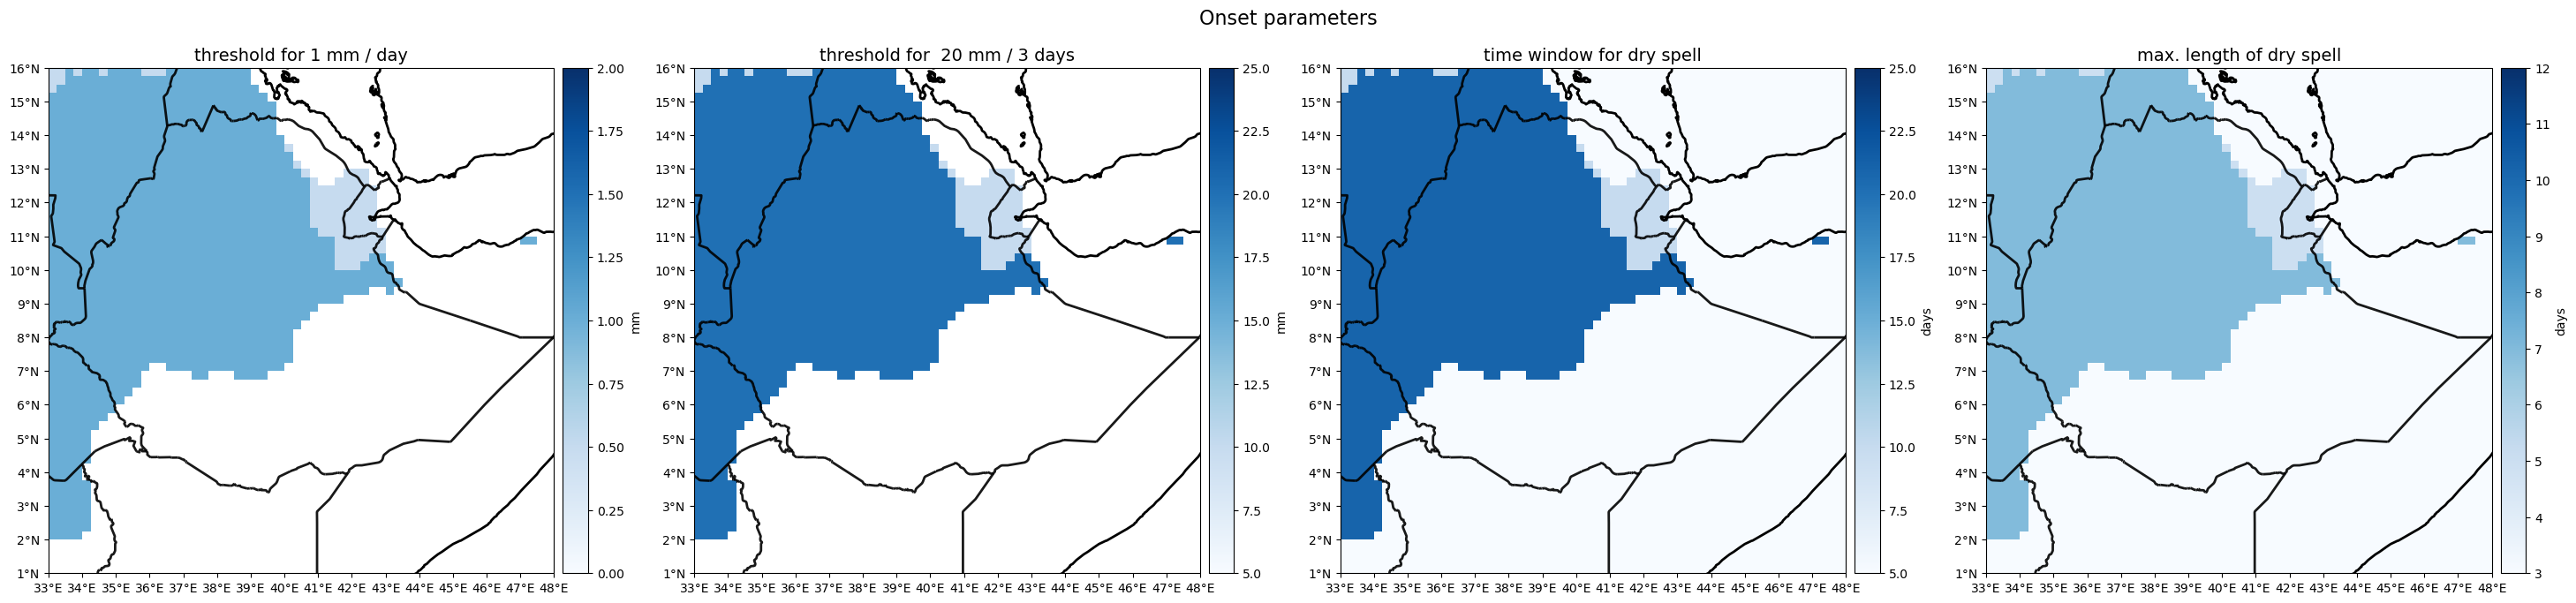

In [6]:
plot_fields (fields_list = [thr_dry_day, thr_wet_spell, wnd_dry_spell, len_dry_spell],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = 'Onset parameters',
          subtitle_list = ['threshold for 1 mm / day','threshold for  20 mm / 3 days', 'time window for dry spell', 'max. length of dry spell'],
          vmin = [0,5,5,3],
          vmax = [2,25,25,12],
          cmap = 'Blues',
          unit = ['mm','mm','days','days'])

Calculate historical rainy season onset dates based on CHIRPSv2 data with the onset definition parameters specified above:

In [7]:
onset_day_hist = calculate_onset_hist(region, month_init_dict[month_start], year_clm_start, year_clm_end, thr_dry_day, thr_wet_spell, wnd_dry_spell, len_dry_spell, chirps_dir)
onset_week_hist = 1 + (onset_day_hist-1)//7

Loading data ...
Calculating rainy season onset dates for 1991 ...
Calculating rainy season onset dates for 1992 ...
Calculating rainy season onset dates for 1993 ...
Calculating rainy season onset dates for 1994 ...
Calculating rainy season onset dates for 1995 ...
Calculating rainy season onset dates for 1996 ...
Calculating rainy season onset dates for 1997 ...
Calculating rainy season onset dates for 1998 ...
Calculating rainy season onset dates for 1999 ...
Calculating rainy season onset dates for 2000 ...
Calculating rainy season onset dates for 2001 ...
Calculating rainy season onset dates for 2002 ...
Calculating rainy season onset dates for 2003 ...
Calculating rainy season onset dates for 2004 ...
Calculating rainy season onset dates for 2005 ...
Calculating rainy season onset dates for 2006 ...
Calculating rainy season onset dates for 2007 ...
Calculating rainy season onset dates for 2008 ...
Calculating rainy season onset dates for 2009 ...
Calculating rainy season onset da

We check whether over the specified region and with the selected start month and onset definition parameters the historical outcome is mostly (except for 5 years or less) a failed onset; in that case, the respective grid points are masked. We also checl for an immediate (within 5 days of the start of the search period) onset, but we still continue processing grid points for which the rainy season has typically already started at the beginning of the search period:

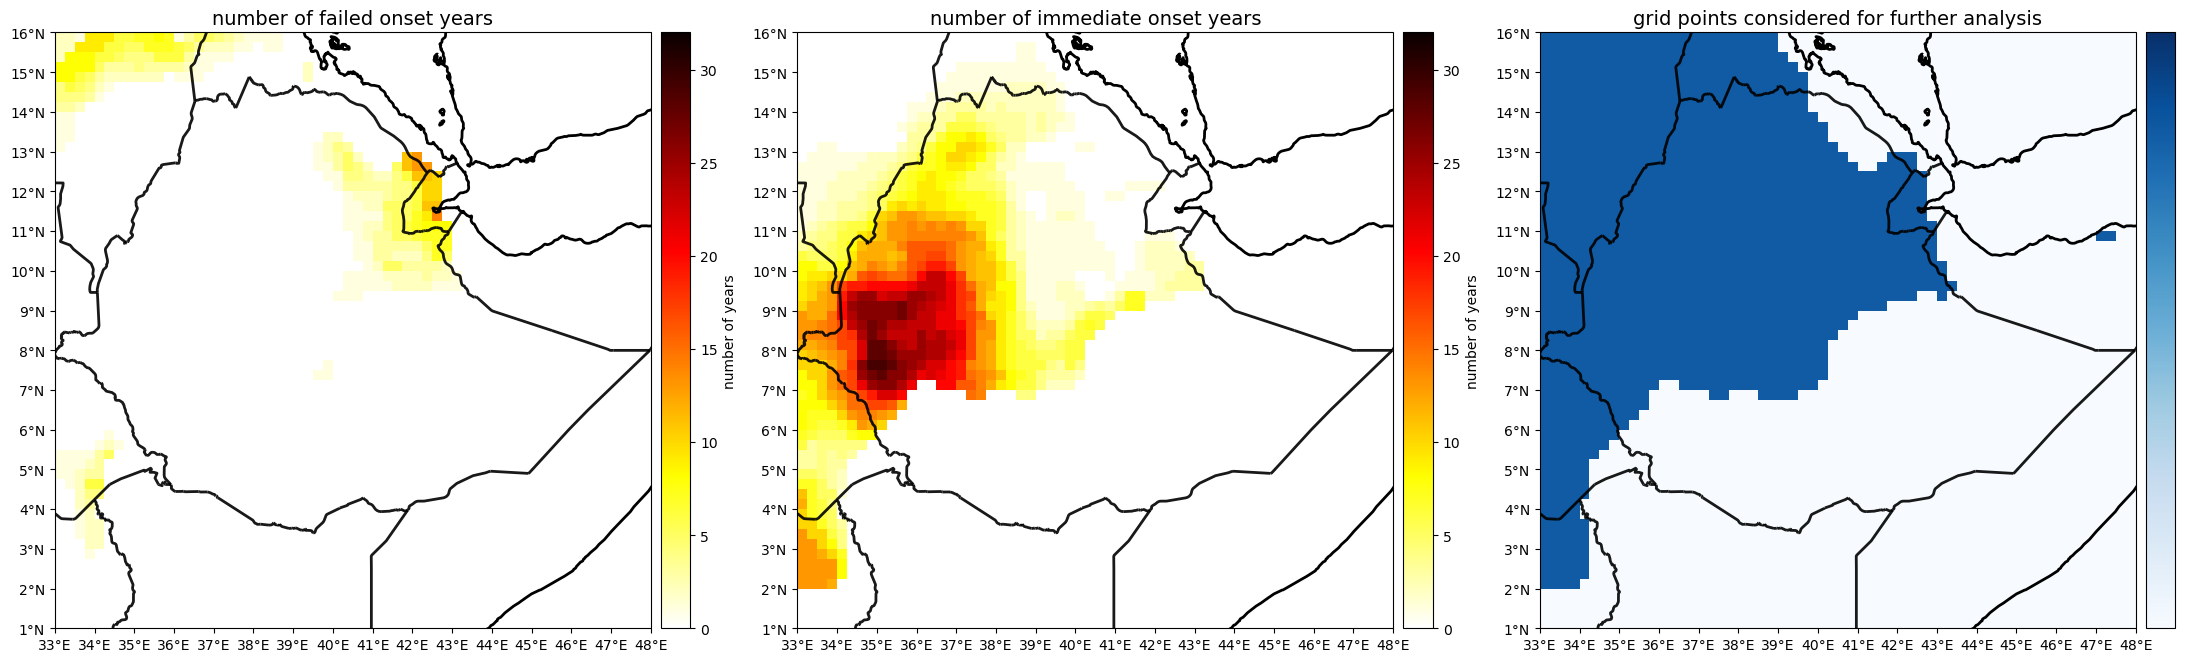

In [8]:
nyrs = onset_day_hist.shape[0]
missing_data_ind = np.all(np.isnan(onset_day_hist), axis=0)
nyrs_failed_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(onset_day_hist<0, axis=0), size=3))
nyrs_immediate_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(np.logical_and(onset_day_hist>0, onset_day_hist<6), axis=0), size=3))
#mask = np.logical_or(missing_data_ind, np.logical_or(nyrs_failed_onset>=nyrs-10, nyrs_immediate_onset>=nyrs-10))
mask = np.logical_or(missing_data_ind, nyrs_failed_onset>=nyrs-5)

plot_fields (fields_list = [nyrs_failed_onset, nyrs_immediate_onset, 1*(~mask)],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = '',
          subtitle_list = ['number of failed onset years', 'number of immediate onset years', 'grid points considered for further analysis'],
          cmap = ['hot_r','hot_r','Blues'],
          vmin = 0,
          vmax = [nyrs,nyrs,1.2],
          ticks = [True, True, []],
          tick_labels = [True, True, []],
          unit = ['number of years', 'number of years',''])

if np.mean(~mask) < 0.1:
    print('\nWarning! Less than 10% of the grid points in the selected region is considered for further analysis! \n\nPlease check if the selected start month and parameters defining onset are suitable for this region.\n')

thr_wet_spell[mask] = np.nan
thr_dry_day[mask] = np.nan

Let's calculate and depict the median and lower/upper onset date tercile in a map, using the mask defined above:

/tmp/ipykernel_21680/2552902886.py:1: RuntimeWarning: All-NaN slice encountered
  onset_day_median = np.nanmedian(np.where(onset_day_hist==-1, np.nan, onset_day_hist), axis=0)
/home/confer/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


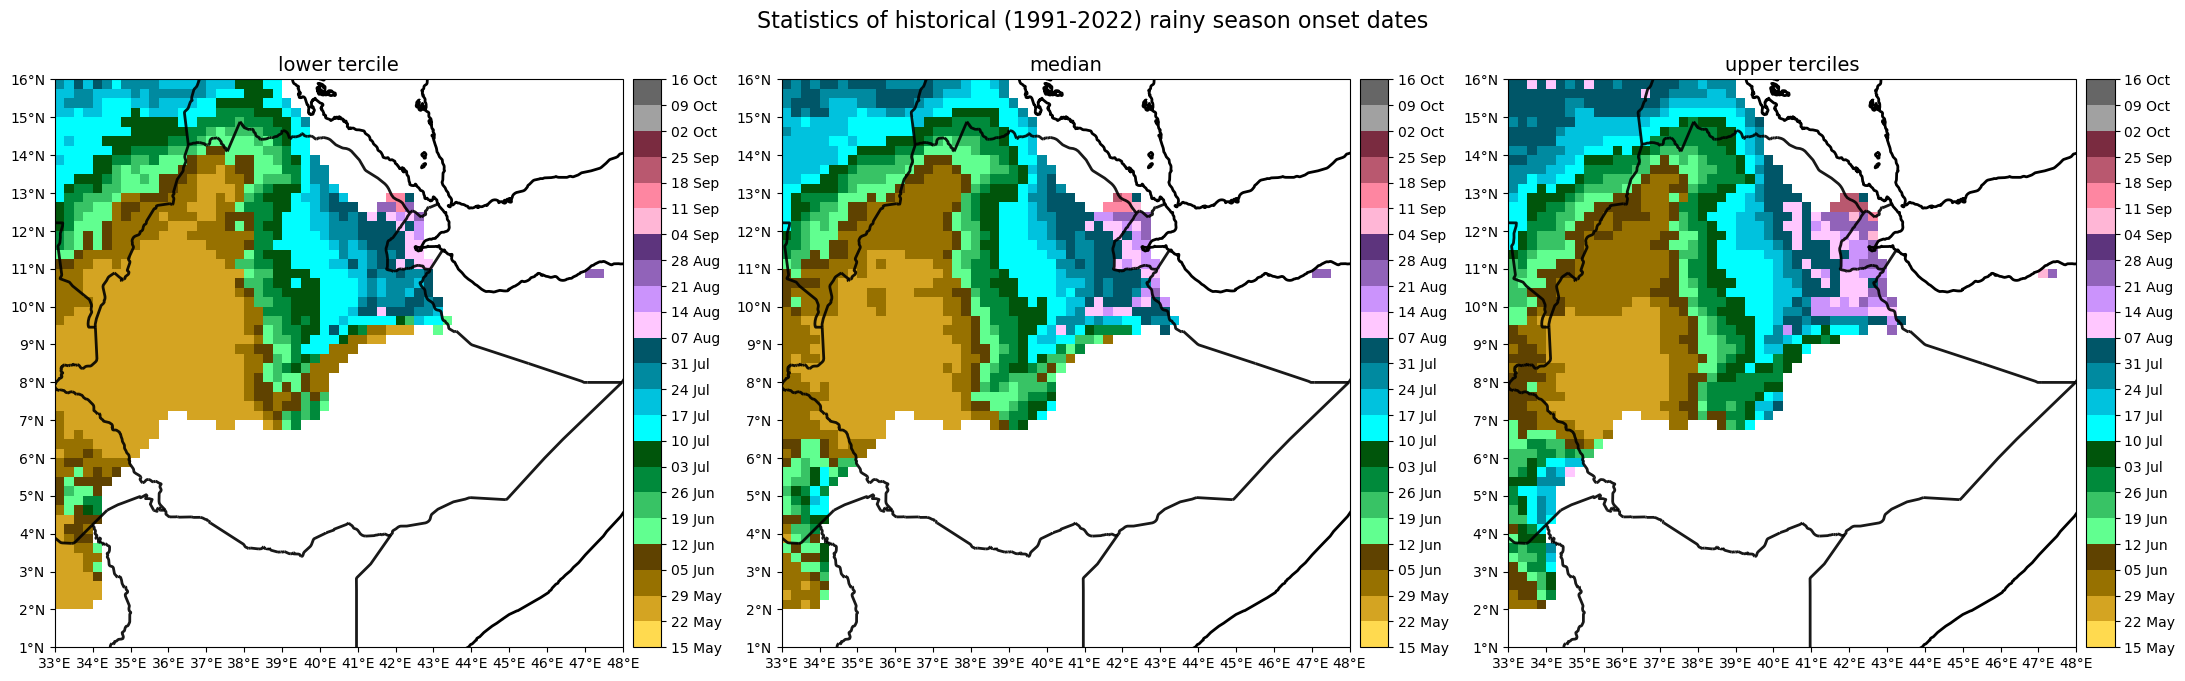

In [9]:
onset_day_median = np.nanmedian(np.where(onset_day_hist==-1, np.nan, onset_day_hist), axis=0)
onset_week_median = np.where(mask, np.nan, 1 + (onset_day_median-1)//7)
onset_day_lower_tercile = np.nanquantile(np.where(onset_day_hist==-1, np.nan, onset_day_hist), q=0.33, axis=0)
onset_week_lower_tercile = np.where(mask, np.nan, 1 + (onset_day_lower_tercile-1)//7)
onset_day_upper_tercile = np.nanquantile(np.where(onset_day_hist==-1, np.nan, onset_day_hist), q=0.67, axis=0)
onset_week_upper_tercile = np.where(mask, np.nan, 1 + (onset_day_upper_tercile-1)//7)

onset_week_labels = [(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b") for iwk in range(nwks+1)]

plot_fields (fields_list = [onset_week_lower_tercile, onset_week_median, onset_week_upper_tercile],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = f'Statistics of historical ({year_clm_start}-{year_clm_end}) rainy season onset dates',
          subtitle_list = ['lower tercile', 'median', 'upper terciles'],
          cmap = newcmp_onset,
          vmin = 0,
          vmax = nwks,
          ticks = [*range(nwks+1)],
          tick_labels = onset_week_labels,
          unit = '')

Now we calculate the bias-adjusted threshold parameters for the selected forecast systems. For a large region, this can take some time:

In [10]:
thr_dry_day_adj = {}
thr_wet_spell_adj = {}

for system in systems:
    thr_dry_day_adj_sys, thr_wet_spell_adj_sys = calculate_adjusted_thresholds(region, month_start, year_clm_start, year_clm_end, system, thr_dry_day, thr_wet_spell, chirps_dir, fcst_dir)
    thr_dry_day_adj[system] = thr_dry_day_adj_sys
    thr_wet_spell_adj[system] = thr_wet_spell_adj_sys

Loading CHIRPS data ...
Loading WRF_D01 forecast data ...
Calculating adjusted dry spell thresholds ...
Calculating adjusted wet spell thresholds ...
Loading CHIRPS data ...
Loading WRF_D02 forecast data ...
Calculating adjusted dry spell thresholds ...
Calculating adjusted wet spell thresholds ...


Depict the bias-adjusted threshold values for 1-day (-> dry spell) and 3-day (wet-spell) precipitation amounts:

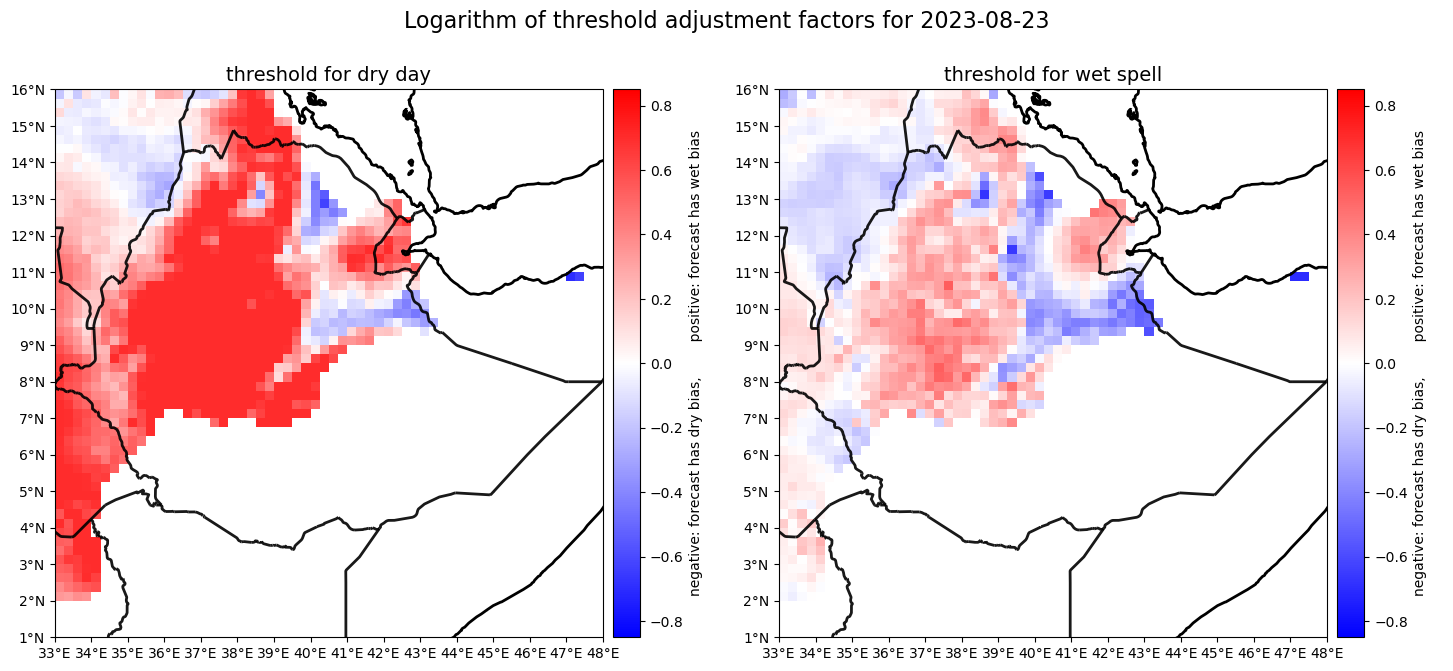

In [17]:
system = 'wrf_d02'  # specific system for which the adjusted thresholds should be visualized
idt = 100           # lead time to be plotted (recall that the adjusted thresholds vary with lead time)

date_str = (pd.Timestamp(f'{year_fcst}-{month_start}-{15}')+pd.Timedelta(days=idt)).strftime("%Y-%m-%d")

thr_dry_day_ratio = thr_dry_day_adj[system][idt,:,:]/thr_dry_day
thr_wet_spell_ratio = thr_wet_spell_adj[system][idt,:,:]/thr_wet_spell

plot_fields (fields_list = [np.log10(thr_dry_day_ratio), np.log10(thr_wet_spell_ratio)],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = f'Logarithm of threshold adjustment factors for {date_str}',
          subtitle_list = ['threshold for dry day','threshold for wet spell'],
          vmin = -0.85,
          vmax = 0.85,
          cmap = 'bwr',
          unit = 'negative: forecast has dry bias,        positive: forecast has wet bias\n')

Now, we are ready to calculate the rainy season onset prediction for the selected year:

In [12]:
onset_day_fcst = {}
onset_week_fcst = {}

for system in systems:
    onset_day_fcst_sys = calculate_onset_fcst(region, month_start, year_fcst, system, thr_dry_day_adj[system], thr_wet_spell_adj[system], wnd_dry_spell, len_dry_spell, lat_chirps, lon_chirps, fcst_dir)
    onset_day_fcst[system] = onset_day_fcst_sys
    onset_week_fcst[system] = 1 + (onset_day_fcst_sys-1)//7

# Augment ensemble by historical rainy season onset dates
#onset_day_fcst['climatology'] = onset_day_hist
#onset_week_fcst['climatology'] = onset_week_hist

onset_day_fcst_all = np.concatenate(list(onset_day_fcst.values()), axis=0)
onset_week_fcst_all =  np.concatenate(list(onset_week_fcst.values()), axis=0)

Loading and interpolating forecast data for year 2023 ...
Calculating rainy season onset dates ...
Loading and interpolating forecast data for year 2023 ...
Calculating rainy season onset dates ...


The above calculation gives us an ensemble of rainy season onset dates at each gridpoint within the selected region. At individual locations, we can compare the probabilities of forecast and historic rainy season onset dates to fall into a particular week:


Text(0.5, 1.0, 'Probability for rainy season onset in Addis Abeba to occur within a given week')

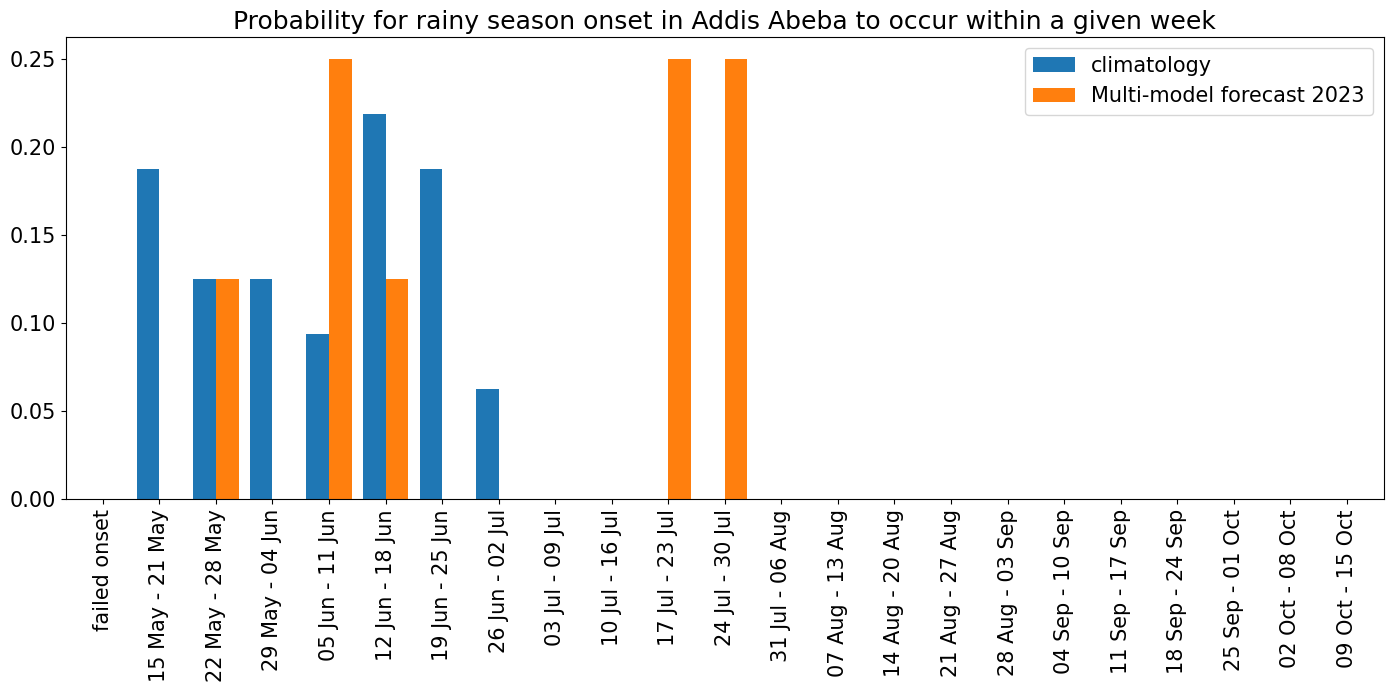

In [13]:
#lon_exmpl = 36.82       # longitude of example location
#lat_exmpl = -1.29       # latitude of example location
#name_exmpl = 'Nairobi'  # name of the selected location

lon_exmpl = 38.75           # longitude of example location
lat_exmpl =  9.00           # latitude of example location
name_exmpl = 'Addis Abeba'  # name of the selected location

#lon_exmpl = 32.56       # longitude of example location
#lat_exmpl =  0.31       # latitude of example location
#name_exmpl = 'Kampala'  # name of the selected location

#lon_exmpl = 45.33         # longitude of example location
#lat_exmpl =  2.05         # latitude of example location
#name_exmpl = 'Moghadishu' # name of the selected location

#lon_exmpl = 39.21            # longitude of example location
#lat_exmpl = -6.84            # latitude of example location
#name_exmpl = 'Dar-es-Salaam' # name of the selected location

#lon_exmpl = 30.09       # longitude of example location
#lat_exmpl = -1.96       # latitude of example location
#name_exmpl = 'Kigali'   # name of the selected location


ix, iy = get_nearest_grid_index(lon_exmpl, lat_exmpl, lon_chirps, lat_chirps)

date_range_weeks = ['failed onset']+[(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b")+' - '+(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk+6)).strftime("%d %b") for iwk in range(nwks)]

df_onset_prob = pd.DataFrame(index=date_range_weeks, columns=['climatology',f'Multi-model forecast {year_fcst}'])
df_onset_prob['climatology'] = np.mean(np.equal.outer(onset_week_hist[:,iy,ix],np.arange(nwks+1)), axis=0)
df_onset_prob[f'Multi-model forecast {year_fcst}'] = np.mean(np.equal.outer(onset_week_fcst_all[:,iy,ix],np.arange(nwks+1)), axis=0)

plt.figure(figsize=(17,6))
ax = plt.subplot(1, 1, 1)
df_onset_prob.plot.bar(ax=ax, width=0.8, fontsize=15).legend(fontsize=15)
ax.set_title(f'Probability for rainy season onset in {name_exmpl} to occur within a given week', fontsize=18)

Now let's calculate and depict probability forecasts for 'failed onset', the median forecast rainy season onset date (across members that do not predict a failed onset), and probability forecasts for rainy season onset to occur earlier/later than the lower/upper climatological tercile date.

/home/confer/mambaforge/lib/python3.10/site-packages/confer_wp3/plotting.py:242: RuntimeWarning: All-NaN slice encountered
  median_fcst = np.where(np.sum(onset_day_fcst==-1, axis=0)>3, np.nan, np.nanmedian(np.where(onset_day_fcst==-1, np.nan, onset_week_fcst), axis=0))


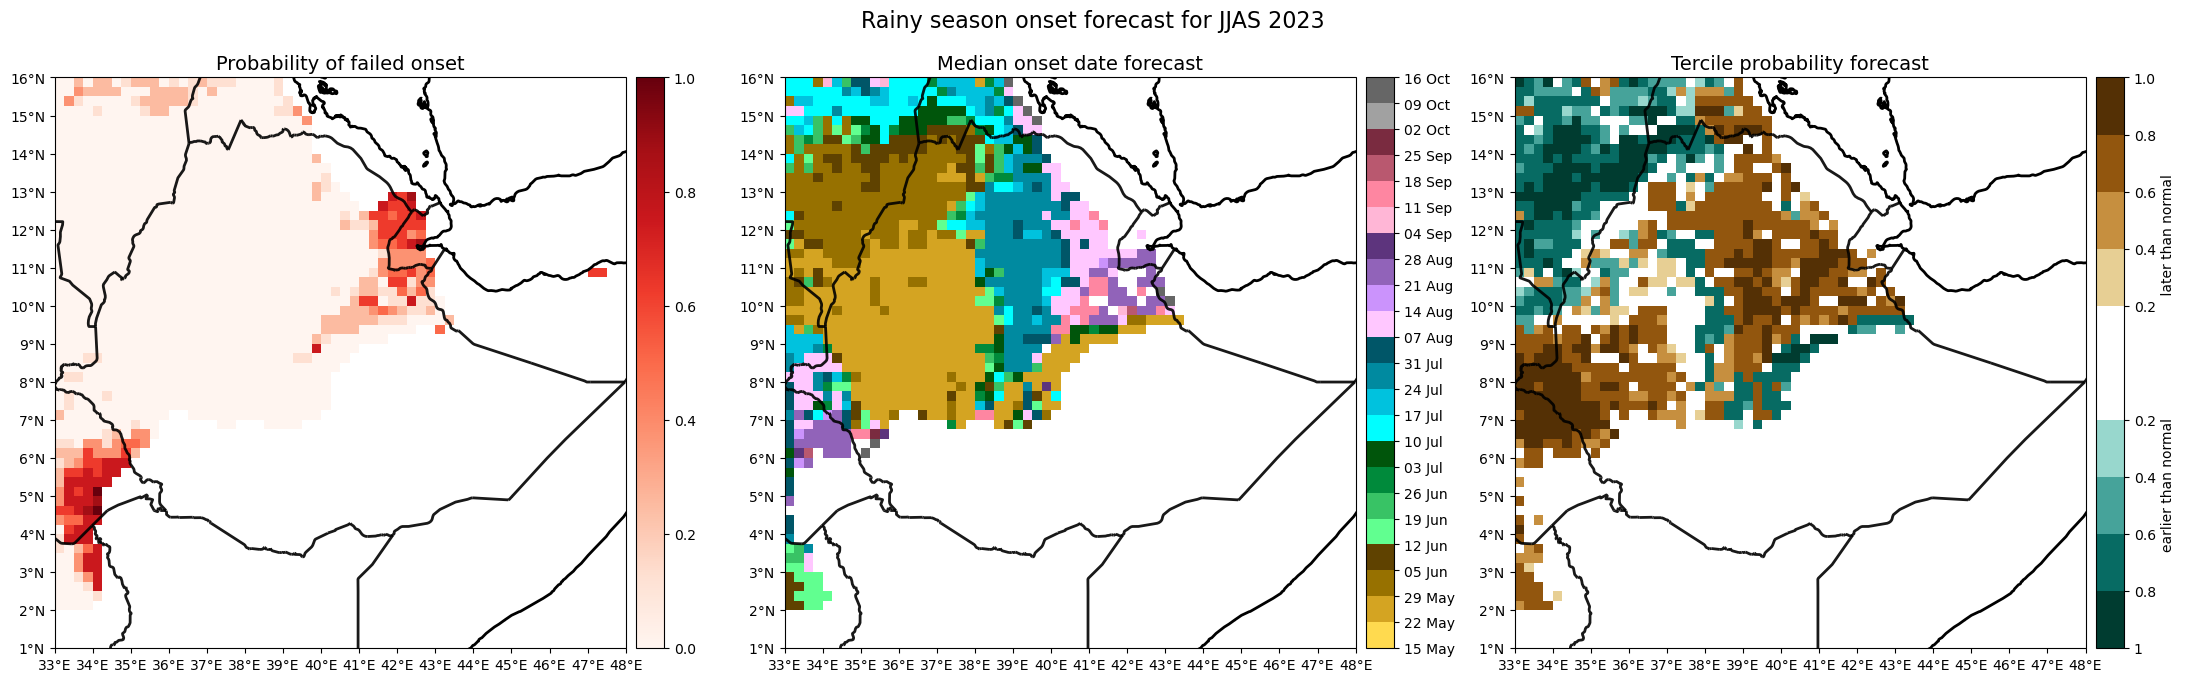

In [15]:
onset_week_labels = [(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b") for iwk in range(nwks+1)]

plot_onset_prediction (onset_day_fcst = onset_day_fcst_all,
          onset_day_lower_tercile = onset_day_lower_tercile,
          onset_day_upper_tercile = onset_day_upper_tercile,
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = f'Rainy season onset forecast for {season} {year_fcst}',
          onset_week_labels = onset_week_labels,
          cmap_onset = newcmp_onset,
          cmap_tcl_probs = newcmp_tercile)

And as a sanity check, we also plot the first four ensemble member forecasts for each forecast system:

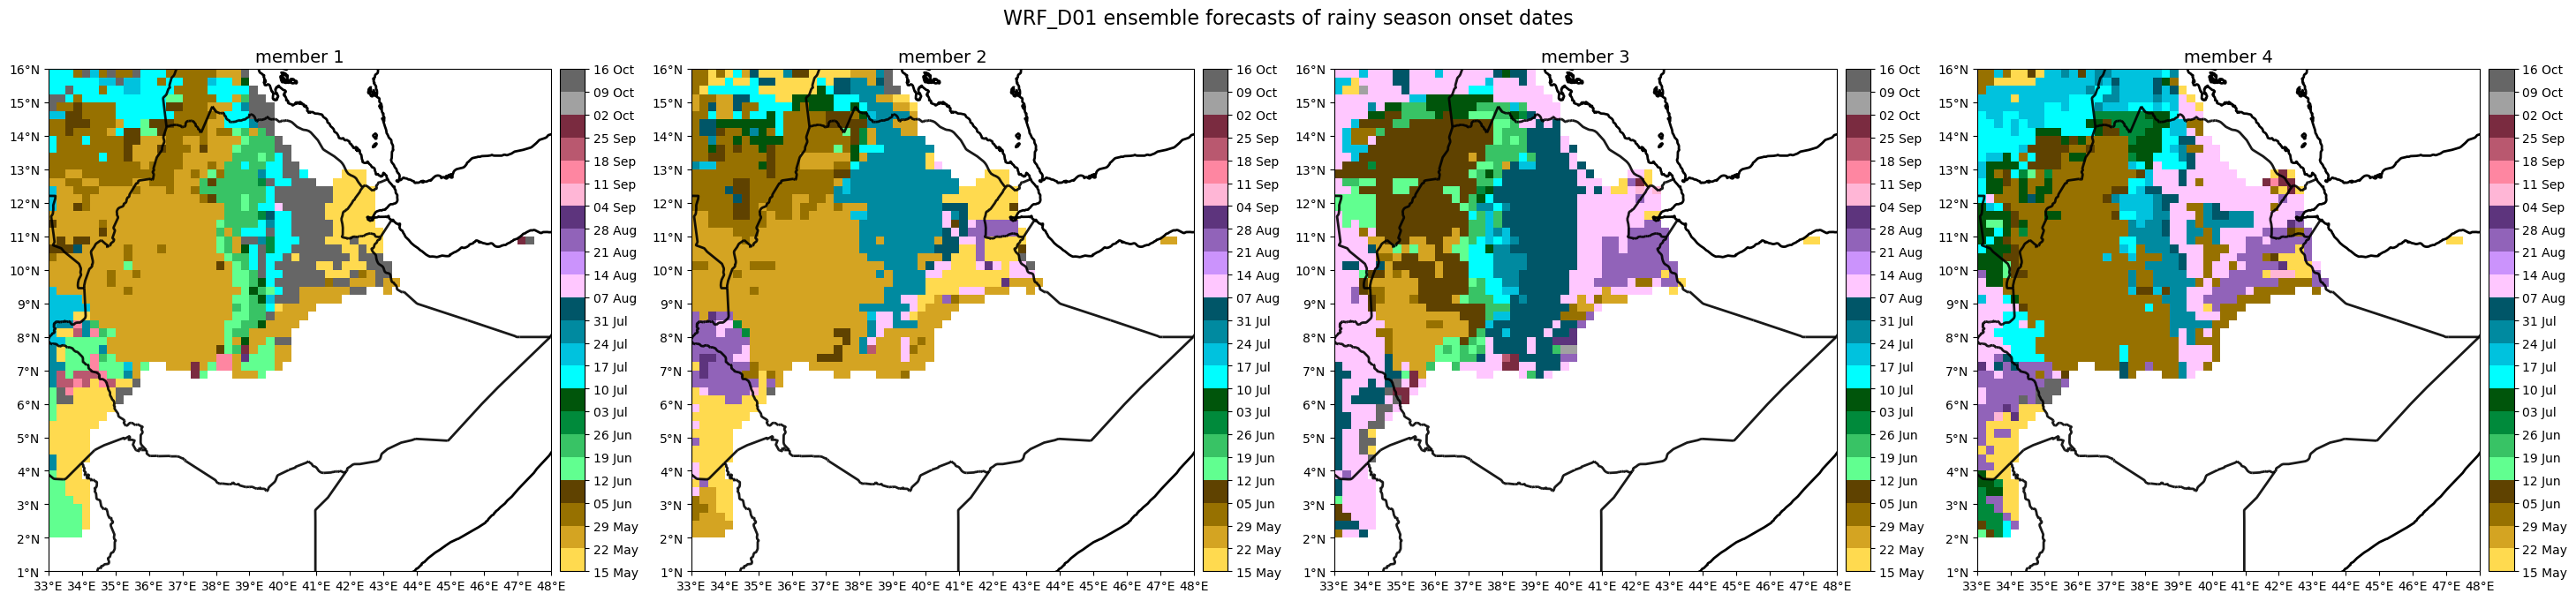

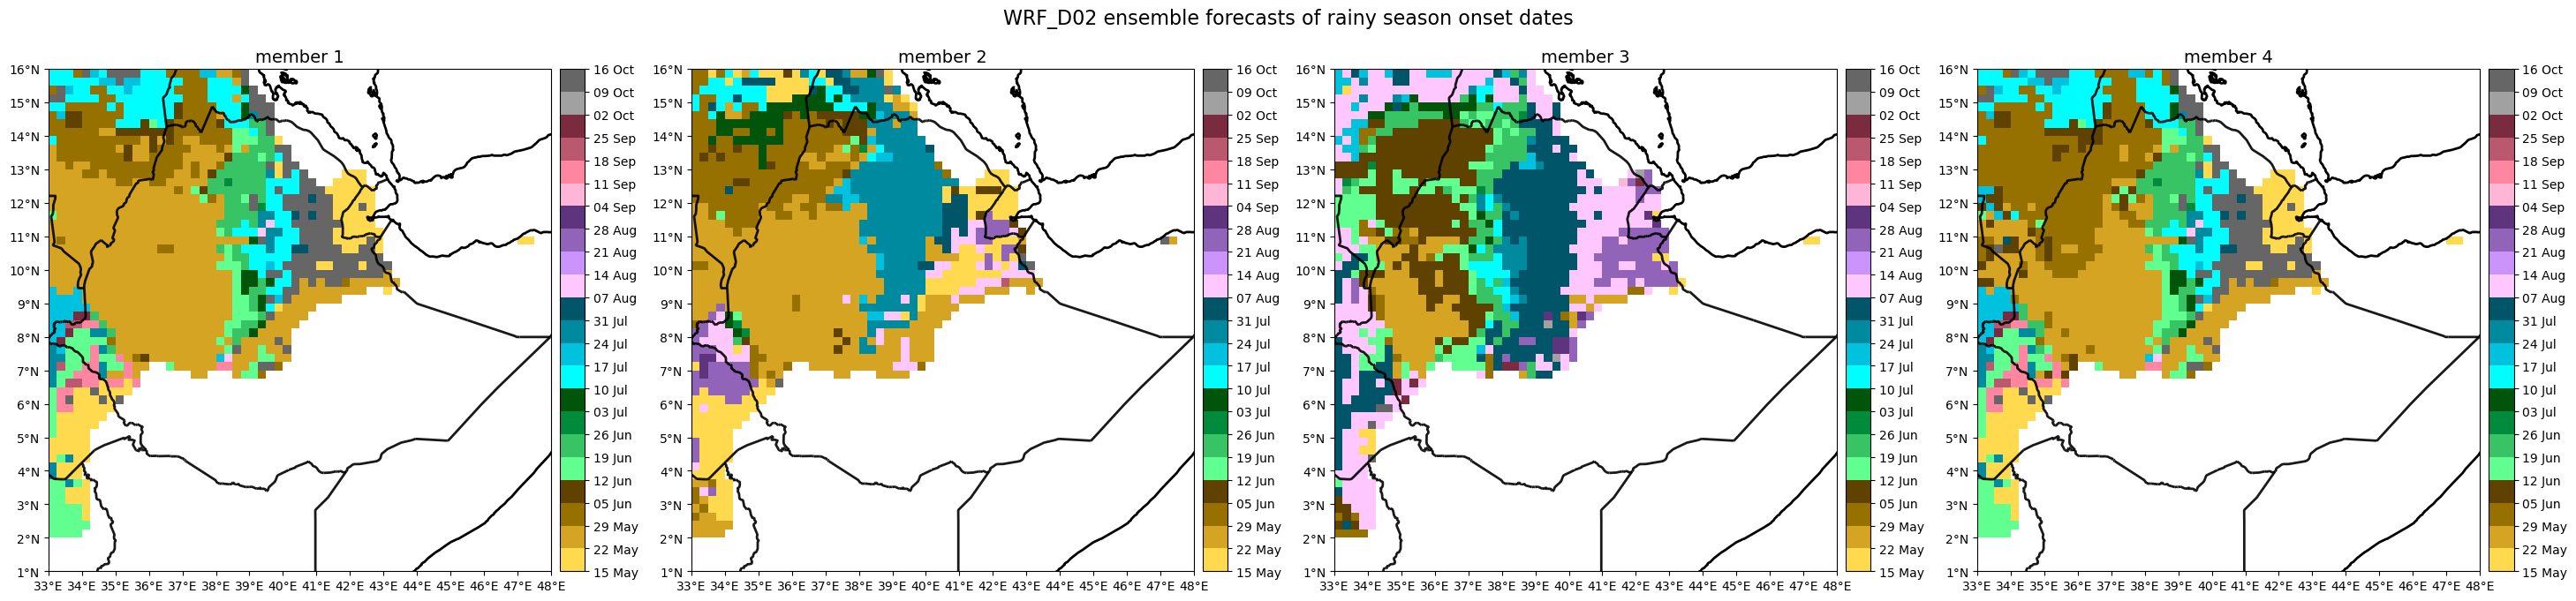

In [16]:
for system in systems:
    plot_fields (fields_list = [np.where(onset_week_fcst[system][i,:,:] < 0, np.nan, onset_week_fcst[system][i,:,:]) for i in range(4)],
              lon = lon_chirps,
              lat = lat_chirps,
              lon_bounds = lon_bounds,
              lat_bounds = lat_bounds,
              main_title = f'{system.upper()} ensemble forecasts of rainy season onset dates',
              subtitle_list = [f'member {i+1}' for i in range(4)],
              cmap = newcmp_onset,
              vmin = 0,
              vmax = nwks,
              ticks = [*range(nwks+1)],
              tick_labels = onset_week_labels,
              unit = '')